In [27]:
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
from Bio import SeqIO
from collections import Counter
import matplotlib.pyplot as plt
from glob import glob
import json
import sys
import pickle
import numpy as np
from scipy.stats import poisson
import time
import sys
import pandas as pd

# Set up file locations.
IDX = 10
KMER_COUNTS_FILE = '/home/groups/dpwall/briannac/alt_haplotypes/data/known_kmer_counts.tsv'
N_KMERS = 1094247 # Number of kmers in KMER_COUNTS_FILE file


PHASINGS_DIR='/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/'
BAM_MAPPINGS_FILE = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'


###################################################################
#################### Loading files. ##############################
###################################################################
print("Loading in files...")
# Load in family region/global region conversion data.
fam_region_to_idx = np.load(PHASINGS_DIR +  'fam_region_to_idx.npy', allow_pickle=True).item()
idx_to_fam_region = np.load(PHASINGS_DIR +  'idx_to_fam_region.npy', allow_pickle=True).item()
global_region_to_idx = np.load(PHASINGS_DIR +  'global_region_to_idx.npy', allow_pickle=True).item()
idx_to_global_region = np.load(PHASINGS_DIR +  'idx_to_global_region.npy', allow_pickle=True).item()
fam_idx_to_global_idx = np.load(PHASINGS_DIR + 'fam_regions_to_global_regions.npy', allow_pickle=True)
family_info = pd.read_pickle(PHASINGS_DIR + 'fam_list.df')

# Info from BAM mappings.
bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)
bam_mappings = bam_mappings[bam_mappings['status']=='Passed_QC_analysis_ready']


# Load in k-mer counts.
family = family_info.index[IDX]
print('family ', family)
samples = [family_info.iloc[IDX]['mother_sample'], family_info.iloc[IDX]['father_sample']] +  family_info.iloc[IDX]['sib_samples']
bam_mappings['counter_idx'] = [i for i in range(len(bam_mappings))]
cols_in_df = bam_mappings.loc[samples].counter_idx.values

###################################################################
#### Prep dict for normalizing k-counts by sample read depth. #####
###################################################################
kmer_length=100
ihart_flagstat_file = '/home/groups/dpwall/briannac/blood_microbiome/data/ihart_flagstat.csv'
flagstat = pd.read_csv(ihart_flagstat_file, index_col=0)
flagstat = flagstat.loc[set(flagstat.index).intersection(bam_mappings.index)]
sex = bam_mappings.loc[flagstat.index].sex_numeric
#bam_mappings = bam_mappings.loc[set(flagstat.index).intersection(bam_mappings.index)]
total_mapped_reads = flagstat.ProperPair*((flagstat.Total_Reads-flagstat.Supplementary-flagstat.Duplicates)/flagstat.Total_Reads)
avg_coverage = total_mapped_reads*150/(6.27e9*(sex.astype(float)==1.0) + 6.37e9*(sex.astype(float)==2.0))
avg_n_100mers = (150-kmer_length)/(150/avg_coverage)
kmer_depth_dict = {k:avg_n_100mers[k] if k in avg_n_100mers else np.mean(avg_n_100mers.values) for k in bam_mappings.index}
avg_k_depth = np.mean(list(kmer_depth_dict.values()))



###########################################################
####### Set up poisson cache and access function. ########
###########################################################
print("Setting up poisson cache...")
max_count = 100
eps = 0
with open('/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/phased_fams/phased_fams_all.pickle', 'rb') as f:
    phased_fam_dict = pickle.load(f)
family_phasings = sorted(list(set([tuple(v) for v in phased_fam_dict[family].values])))
poisson_cache = [[], []]
avg_kmer_depth=np.mean(list(kmer_depth_dict.values()))
poisson_cache[0] = [poisson.pmf(k=k, mu=avg_kmer_depth) for k in range(max_count)]
poisson_cache[1] = [poisson.pmf(k=k, mu=2*avg_kmer_depth) for k in range(max_count)]

def cached_poisson_pmf(k,g):
    if (g==0) & (k!=0): return eps
    if (g==0) & (k==0): return 1-3*eps
    if k>=max_count: return eps
    return min(max(poisson_cache[g-1][k], eps), 1-3*eps)



###########################################################
#### Computing phasing x global region Presence matrix ####
###########################################################
print("Computing phasing x global region presence matrix...")
family_phasings_to_idx_dict = {p:i for i,p in enumerate(family_phasings)}
global_regions_phasings_fam = np.zeros((len(global_region_to_idx),len(family_phasings))) 

for k,v in pd.DataFrame(phased_fam_dict[family].apply(lambda x: tuple(x), axis=1)).iterrows():
    for i in fam_idx_to_global_idx[fam_region_to_idx[k]]:
        global_regions_phasings_fam[i,family_phasings_to_idx_dict[v[0]]] = 1
        
# If we don't know the phasing, then default to most common phasing.
# Doing it this way will assign unknown regions the most common likelihood of the whole family's genome.
# If we didn't do this, we would end up with have the likelihood=0 at regions w/unknown phases, this will give unknown regions an unfair advantage.
impute_vector = np.zeros(len(family_phasings))
impute_vector[np.argmax(global_regions_phasings_fam.sum(axis=0))] = 1

#impute_vector = np.apply_along_axis(arr=global_regions_phasings_fam[np.where(global_regions_phasings_fam.sum(axis=1)!=0)[0], :], func1d=np.median, axis=0)
for i in np.where(global_regions_phasings_fam.sum(axis=1)==0)[0]:
    global_regions_phasings_fam[i,:]=impute_vector

print("DONE!")

Loading in files...
family  AU0037
Setting up poisson cache...
Computing phasing x global region presence matrix...
DONE!


In [70]:
###########################################################
###### Computing phasing x k-mer Likelihood matrix ########
###########################################################
print("Computing phasing x k-mer region likelihood matrix...")
phases_kmers_L = np.zeros((N_KMERS,len(family_phasings)))  # Initializ likelihood matrix (phases as rows, kmers as columns)
chunks = pd.read_table(KMER_COUNTS_FILE, header=None,  chunksize=10000, usecols=list(1+cols_in_df), skiprows=10000)
for kmer_counts in chunks:
    kmer_counts.columns = samples
    print(kmer_counts.index[0])
    norm_mult = np.array([avg_k_depth/kmer_depth_dict[c] for c in kmer_counts.columns])
    kmer_counts = kmer_counts[((kmer_counts>0).sum(axis=1)>0)]
    kmer_counts_normed = kmer_counts.apply(lambda x: round(x*norm_mult), axis=1).astype(int)
    poss_kmer_counts = set([tuple(v) for v in kmer_counts_normed.values])
    family_probability_cache = dict()
    if (0,7,0,0,0) in poss_kmer_counts: print("yay")
    else: 
        print('boo')
        continue
    for phases_ch in family_phasings:
        possible_gs = [(0,0), (0,1), (1,0), (1,1)]
        for kmer_count_set in poss_kmer_counts:
            k_m = kmer_count_set[0]
            k_p = kmer_count_set[1]
            k_cs = kmer_count_set[2:]
            if ((k_m, k_p, *k_cs), phases_ch) in family_probability_cache: print("ERROR!!")
            family_probability_cache[((k_m, k_p, *k_cs), phases_ch)] = round(np.log2(sum(
                [cached_poisson_pmf(k_m,sum(g_m))*
                 cached_poisson_pmf(k_p,sum(g_p))*
                 np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch)]
                        ) for g_p in possible_gs for g_m in possible_gs])),3)
    print('Done making cached dictionary.')
    # Compute likelihood matrix (phasings x kmers)
    for i,p in enumerate(family_phasings):
        phases_kmers_L[kmer_counts_normed.index, i] = [family_probability_cache[(k, p)] for k in kmer_counts_normed.apply(lambda x: tuple(x), axis=1).values]
    print('Done compute likelihood matrix')
    break

Computing phasing x k-mer region likelihood matrix...
0
boo
10000
boo
20000
boo
30000
boo
40000
boo
50000
boo
60000


KeyboardInterrupt: 

In [72]:
a = pd.read_table(KMER_COUNTS_FILE, header=None,  nrows=20000, usecols=list(1+cols_in_df), skiprows=10000)

In [76]:
a[a/]

,125,204,205,206,207
14573,0,7,2,6,5
17064,0,7,7,4,7
17065,0,7,7,4,7
17066,0,7,7,5,5
17067,0,7,7,5,5


In [61]:
a = pd.read_table(KMER_COUNTS_FILE, header=None, nrows=200, index_col=0)#, usecols=[0] + [1,2])
a

,1,2,3,4,5,6,7,8,9,10,...,4560,4561,4562,4563,4564,4565,4566,4567,4568,4569
0,,,,,,,,,,,,,,,,,,,,,
168340,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
168341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
168342,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
168343,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
168344,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202588,5,7,5,4,11,6,5,7,4,3,...,5,9,4,5,6,9,5,6,0,3
202589,5,6,5,4,11,6,5,6,4,2,...,5,7,4,5,6,9,5,6,0,3
202590,5,5,5,4,11,6,5,5,4,2,...,5,6,4,5,6,9,5,5,0,3


In [60]:
a

,1,2
0,,
168340,0,0
168341,0,0
168342,0,0
168343,0,0
168344,0,0
...,...,...
202588,5,7
202589,5,6
202590,5,5


In [52]:
a

,0,1,2,3,4,5,6,7,8,9,...,4560,4561,4562,4563,4564,4565,4566,4567,4568,4569
0,168340,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,168341,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,168342,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,168343,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,168344,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,202588,5,7,5,4,11,6,5,7,4,...,5,9,4,5,6,9,5,6,0,3
196,202589,5,6,5,4,11,6,5,6,4,...,5,7,4,5,6,9,5,6,0,3
197,202590,5,5,5,4,11,6,5,5,4,...,5,6,4,5,6,9,5,5,0,3
198,202591,6,5,5,4,11,6,6,6,4,...,4,6,4,5,5,9,4,5,0,2


In [48]:
a

,0,1,2,3,4,5,6,7,8,9,...,4560,4561,4562,4563,4564,4565,4566,4567,4568,4569
0,168340,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,168341,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,168342,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,168343,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,168344,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,202588,5,7,5,4,11,6,5,7,4,...,5,9,4,5,6,9,5,6,0,3
196,202589,5,6,5,4,11,6,5,6,4,...,5,7,4,5,6,9,5,6,0,3
197,202590,5,5,5,4,11,6,5,5,4,...,5,6,4,5,6,9,5,5,0,3
198,202591,6,5,5,4,11,6,6,6,4,...,4,6,4,5,5,9,4,5,0,2


In [33]:
family_probability_cache[(0,7,0,0,0), ((0, 0), (0, 0), (0, 0))]

-2.9

In [2]:
###########################################################
#################### Saving data ##########################
###########################################################
print("Done computing phasing x k-mer matrix for family!")
print("Saving...")
np.savetxt(OUT_DIR + 'likelihood_matrix_phasings_kmers_fam%03d.tsv' % IDX, phases_kmers_L, delimiter='\t', fmt='%.3f')
print('saved to ', OUT_DIR + 'likelihood_matrix_phasings_kmers_fam%03d.tsv' % IDX)

np.savetxt(OUT_DIR + 'global_regions_phasings_fam%03d.tsv' % IDX, global_regions_phasings_fam, delimiter='\t', fmt='%.0f')
print('saved to ', OUT_DIR +  'global_regions_phasings_fam%03d.tsv' % IDX)

Loading in files...
family  AU0037
Setting up poisson cache...


In [25]:
KMER_COUNTS_FILE = '/home/groups/dpwall/briannac/alt_haplotypes/results/simulated_data/kmer_counts.tsv'
kmer_counts = pd.read_table(KMER_COUNTS_FILE, index_col=0, nrows=100000)
#kmer_names = pd.read_table(KMERS_FILE, header=None, index_col=0, nrows=100000)
#kmer_counts.columns = bam_mappings.index
kmer_counts = kmer_counts[((kmer_counts>0).mean(axis=1)>.05) & ((kmer_counts>0).mean(axis=1)<.5)]

In [26]:
kmer_counts

,10C102511,10C102510,10C102512,10C102513,05C50068,05C50067,05C50069,05C50070,07C62527,07C62529,...,05C40075,03C16201,03C16002,03C16202,03C16203,05C46413,05C46420,05C46414,05C46415,05C46416
"(94223, 0.08285757448149722)",7,12,7,9,0,8,0,0,0,0,...,7,0,5,9,9,0,0,0,0,0
"(12995, 0.12255943984653905)",0,0,0,0,0,0,0,0,0,9,...,0,0,8,0,0,0,4,0,6,10
"(52482, 0.032385236456679234)",0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
"(110216, 0.07585792666008406)",0,0,0,0,3,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
"(37588, 0.15530975728204277)",0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,8,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(67362, 0.12374337823044024)",5,0,0,0,0,0,0,0,0,0,...,9,5,0,0,0,9,0,0,9,10
"(128334, 0.2145203883639586)",0,0,0,0,0,10,6,7,0,0,...,0,16,8,20,23,0,0,0,0,0
"(218683, 0.21546034283858717)",2,0,10,0,0,0,0,0,14,0,...,0,0,16,3,5,0,8,0,0,0
"(177966, 0.3126140465383386)",0,5,4,4,7,10,17,20,0,0,...,8,0,7,4,9,0,0,0,0,0


In [15]:
family_probability_cache = dict()
for phases_ch in family_phasings:
        possible_gs = [(0,0), (0,1), (1,0), (1,1)]
        for kmer_count_set in [(0,7,0,0,0), (1,2,0,0,0)]:
            k_m = kmer_count_set[0]
            k_p = kmer_count_set[1]
            k_cs = kmer_count_set[2:]
            family_probability_cache[((k_m, k_p, *k_cs), phases_ch)] = round(np.log2(sum(
                [cached_poisson_pmf(k_m,sum(g_m))*
                 cached_poisson_pmf(k_p,sum(g_p))*
                 np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch)]
                        ) for g_p in possible_gs for g_m in possible_gs])),3)

In [16]:
family_probability_cache

{((0, 7, 0, 0, 0), ((0, 0), (0, 0), (0, 0))): -2.9,
 ((1, 2, 0, 0, 0), ((0, 0), (0, 0), (0, 0))): -10.202,
 ((0, 7, 0, 0, 0), ((0, 0), (0, 0), (0, 1))): -11.314,
 ((1, 2, 0, 0, 0), ((0, 0), (0, 0), (0, 1))): -18.615,
 ((0, 7, 0, 0, 0), ((0, 0), (0, 0), (1, 0))): -2.904,
 ((1, 2, 0, 0, 0), ((0, 0), (0, 0), (1, 0))): -18.615,
 ((0, 7, 0, 0, 0), ((0, 0), (0, 0), (1, 1))): -11.318,
 ((1, 2, 0, 0, 0), ((0, 0), (0, 0), (1, 1))): -27.029,
 ((0, 7, 0, 0, 0), ((0, 0), (0, 1), (0, 0))): -11.314,
 ((1, 2, 0, 0, 0), ((0, 0), (0, 1), (0, 0))): -18.615,
 ((0, 7, 0, 0, 0), ((0, 0), (0, 1), (0, 1))): -11.314,
 ((1, 2, 0, 0, 0), ((0, 0), (0, 1), (0, 1))): -18.615,
 ((0, 7, 0, 0, 0), ((0, 0), (0, 1), (1, 0))): -11.318,
 ((1, 2, 0, 0, 0), ((0, 0), (0, 1), (1, 0))): -27.029,
 ((0, 7, 0, 0, 0), ((0, 0), (0, 1), (1, 1))): -11.318,
 ((1, 2, 0, 0, 0), ((0, 0), (0, 1), (1, 1))): -27.029,
 ((0, 7, 0, 0, 0), ((0, 0), (1, 0), (0, 0))): -2.904,
 ((1, 2, 0, 0, 0), ((0, 0), (1, 0), (0, 0))): -18.615,
 ((0, 7, 0, 0, 

In [3]:
chunks = pd.read_table(KMER_COUNTS_FILE, header=None,  chunksize=10000, usecols=1+cols_in_df)
for kmer_counts in chunks:
    kmer_counts.columns = samples
    print(kmer_counts.index[0])
    norm_mult = np.array([avg_k_depth/kmer_depth_dict[c] for c in kmer_counts.columns])
    kmer_counts = kmer_counts[((kmer_counts>0).sum(axis=1)>0)]
    kmer_counts_normed = kmer_counts.apply(lambda x: round(x*norm_mult), axis=1).astype(int)
    poss_kmer_counts = set([tuple(v) for v in kmer_counts_normed.values])
    family_probability_cache = dict()
    
    for phases_ch in family_phasings:
        possible_gs = [(0,0), (0,1), (1,0), (1,1)]
        for kmer_count_set in poss_kmer_counts:
            k_m = kmer_count_set[0]
            k_p = kmer_count_set[1]
            k_cs = kmer_count_set[2:]
            family_probability_cache[((k_m, k_p, *k_cs), phases_ch)] = round(np.log2(sum(
                [cached_poisson_pmf(k_m,sum(g_m))*
                 cached_poisson_pmf(k_p,sum(g_p))*
                 np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch)]
                        ) for g_p in possible_gs for g_m in possible_gs])),3)
    print('Done making cached dictionary.')
    # Compute likelihood matrix (phasings x kmers)
    for i,p in enumerate(family_phasings):
        phases_kmers_L[kmer_counts_normed.index, i] = [family_probability_cache[(k, p)] for k in kmer_counts_normed.apply(lambda x: tuple(x), axis=1).values]
    print('Done compute likelihood matrix')
    

###########################################################
#################### Saving data ##########################
###########################################################
print("Done computing phasing x k-mer matrix for family!")
print("Saving...")
np.savetxt(OUT_DIR + 'likelihood_matrix_phasings_kmers_fam%03d.tsv' % IDX, phases_kmers_L, delimiter='\t', fmt='%.3f')
print('saved to ', OUT_DIR + 'likelihood_matrix_phasings_kmers_fam%03d.tsv' % IDX)

np.savetxt(OUT_DIR + 'global_regions_phasings_fam%03d.tsv' % IDX, global_regions_phasings_fam, delimiter='\t', fmt='%.0f')
print('saved to ', OUT_DIR +  'global_regions_phasings_fam%03d.tsv' % IDX)

Loading in files...
family  AU0012
Setting up poisson cache...
Computing phasing x global region presence matrix...
Done computing phasing x region matrix for family!


In [4]:
###########################################################
###### Computing phasing x k-mer Likelihood matrix ########
###########################################################
print("Computing phasing x k-mer region likelihood matrix...")
phases_kmers_L = np.zeros((N_KMERS,len(family_phasings)))  # Initializ likelihood matrix (phases as rows, kmers as columns)
chunks = pd.read_table(KMER_COUNTS_FILE, header=None,  chunksize=10000, usecols=1+cols_in_df)
for kmer_counts in chunks:
    kmer_counts.columns = samples
    print(kmer_counts.index[0])
    norm_mult = np.array([avg_k_depth/kmer_depth_dict[c] for c in kmer_counts.columns])
    kmer_counts = kmer_counts[((kmer_counts>0).sum(axis=1)>0)]
    kmer_counts_normed = kmer_counts.apply(lambda x: round(x*norm_mult), axis=1).astype(int)
    poss_kmer_counts = set([tuple(v) for v in kmer_counts_normed.values])
    family_probability_cache = dict()
    
    for phases_ch in family_phasings:
        possible_gs = [(0,0),(0,1), (1,0), (1,1)]
        for kmer_count_set in poss_kmer_counts:
            k_m = kmer_count_set[0]
            k_p = kmer_count_set[1]
            k_cs = kmer_count_set[2:]
            family_probability_cache[((k_m, k_p, *k_cs), phases_ch)] = round(np.log2(sum(
                [cached_poisson_pmf(k_m,sum(g_m))*
                 cached_poisson_pmf(k_p,sum(g_p))*
                 np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch)]
                        ) for g_p in possible_gs for g_m in possible_gs])),3)
    print('Done making cached dictionary.')
    print(max(family_probability_cache.values()), min(family_probability_cache.values()), np.mean(list(family_probability_cache.values())))
    print(min(kmer_counts_normed.index), max(kmer_counts_normed.index))
    # Compute likelihood matrix (phasings x kmers)
    for i,p in enumerate(family_phasings):
        phases_kmers_L[kmer_counts_normed.index, i] = [family_probability_cache[(k, p)] for k in kmer_counts_normed.apply(lambda x: tuple(x), axis=1).values]
    print(Counter(family_probability_cache.values()))
    print('Done compute likelihood matrix')
    break


Computing phasing x k-mer region likelihood matrix...
0
Done making cached dictionary.
-39.858 -62.439 -60.6725195068664
109 9999
Counter({-62.439: 10168, -55.242: 2200, -48.045: 385, -40.849: 40, -47.055: 11, -39.858: 6, -46.47: 6})
Done compute likelihood matrix


In [65]:
global_regions_phasings_fam = np.zeros((len(global_region_to_idx),len(family_phasings))) 

for k,v in pd.DataFrame(phased_fam_dict[family].apply(lambda x: tuple(x), axis=1)).iterrows():
    for i in fam_idx_to_global_idx[fam_region_to_idx[k]]:
        global_regions_phasings_fam[i,family_phasings_to_idx_dict[v[0]]] = 1
        

In [67]:
impute_vector = global_regions_phasings_fam[np.where(global_regions_phasings_fam.sum(axis=1)!=0)[0], :].mean(axis=0)
for i in np.where(global_regions_phasings_fam.sum(axis=1)==0)[0]:
    global_regions_phasings_fam[i,:]=impute_vector
print("Done computing phasing x region matrix for family!")

Done computing phasing x region matrix for family!


In [68]:
Counter(global_regions_phasings_fam.flatten())

Counter({1.0: 225170,
         0.0: 675510,
         0.19613181152018475: 143,
         0.22597592929786384: 143,
         0.291704045832038: 143,
         0.2861882133499134: 143})

In [52]:
global_regions_phasings_fam.shape

(225313, 4)

In [29]:
impute_vector = global_regions_phasings_fam.mean(axis=1) 
for i in np.where(global_regions_phasings_fam.sum(axis=0)==0)[0]:
    global_regions_phasings_fam[:,i]=impute_vector
print("Done computing phasing x region matrix for family!")

2

In [24]:
[cached_poisson_pmf(k_m,sum(g_m))*
                 cached_poisson_pmf(k_p,sum(g_p))*
                 np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch)]
                        ) for g_p in possible_gs for g_m in possible_gs]

[1.0000000000000004e-20,
 1.0000000000000004e-20,
 1.0000000000000004e-20,
 1.0000000000000004e-20,
 1.0000000000000004e-20,
 1.0000000000000004e-20,
 1.0000000000000004e-20,
 1.0000000000000004e-20,
 1.0000000000000004e-20,
 1.0000000000000004e-20,
 1.0000000000000004e-20,
 1.0000000000000004e-20,
 1.0000000000000004e-20,
 1.0000000000000004e-20,
 1.0000000000000004e-20,
 1.0000000000000004e-20]

In [19]:
Counter(family_probability_cache.values())

Counter({-55.242: 2200,
         -62.439: 10168,
         -48.045: 385,
         -39.858: 6,
         -47.055: 11,
         -40.849: 40,
         -46.47: 6})

In [17]:
family_phasings

[((0, 0), (0, 0)), ((0, 1), (0, 0)), ((1, 0), (0, 0)), ((1, 1), (0, 0))]

In [16]:
set([i[1] for i in family_probability_cache.keys()])

{((0, 0), (0, 0)), ((0, 1), (0, 0)), ((1, 0), (0, 0)), ((1, 1), (0, 0))}

In [10]:
Counter(kmer_counts_normed.apply(lambda x: tuple(x), axis=1).values)

Counter({(3, 0, 0, 0): 49,
         (3, 0, 2, 0): 9,
         (4, 0, 2, 0): 7,
         (5, 0, 2, 0): 2,
         (5, 0, 3, 0): 2,
         (5, 0, 3, 2): 3,
         (5, 0, 3, 3): 2,
         (5, 0, 4, 3): 1,
         (6, 0, 4, 3): 1,
         (7, 0, 4, 3): 3,
         (7, 0, 4, 4): 9,
         (7, 2, 4, 4): 1,
         (7, 3, 4, 4): 3,
         (8, 3, 4, 4): 3,
         (8, 3, 6, 6): 1,
         (8, 3, 6, 7): 2,
         (8, 3, 7, 7): 3,
         (10, 3, 9, 7): 3,
         (10, 3, 9, 6): 3,
         (11, 3, 9, 7): 4,
         (11, 3, 10, 8): 1,
         (11, 3, 11, 6): 1,
         (12, 3, 11, 6): 1,
         (13, 3, 11, 5): 4,
         (12, 3, 10, 5): 5,
         (11, 3, 9, 4): 2,
         (12, 3, 10, 4): 4,
         (11, 5, 10, 4): 3,
         (12, 5, 10, 4): 1,
         (13, 5, 10, 4): 5,
         (13, 5, 10, 5): 4,
         (13, 6, 10, 5): 2,
         (12, 7, 10, 4): 1,
         (11, 7, 10, 4): 1,
         (11, 7, 10, 5): 3,
         (10, 7, 9, 4): 4,
         (8, 5, 9, 3): 5,
    

In [101]:
len(family_info)

875

(array([5.580e+02, 2.254e+03, 1.561e+03, 1.260e+02, 3.700e+01, 1.800e+01,
        7.000e+00, 3.000e+00, 3.000e+00, 2.000e+00]),
 array([ 4.19317236,  5.08871616,  5.98425995,  6.87980375,  7.77534754,
         8.67089134,  9.56643513, 10.46197892, 11.35752272, 12.25306651,
        13.14861031]),
 <BarContainer object of 10 artists>)

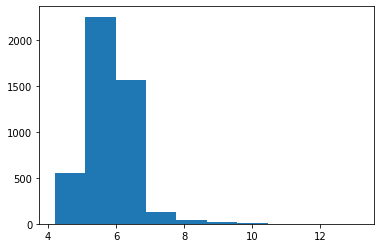

In [99]:
plt.hist(kmer_depth_dict.values())

In [93]:
print("Setting up poisson cache...")

def cached_poisson_pmf(k,g):
    if k>=len(poisson_cache): return 1-3*eps
    return min(max(poisson_cache[g-1][k], eps), 1-3*eps)

eps = np.log2(.0001)
max_count = 25+1

with open('/home/groups/dpwall/briannac/alt_haplotypes/data/phasings/phased_fams/phased_fams_all.pickle', 'rb') as f:
    phased_fam_dict = pickle.load(f)
family_phasings = set([tuple(v) for v in phased_fam_dict[family].values])
poisson_cache = [[], []]
avg_kmer_depth=np.mean(list(kmer_depth_dict.values()))

poisson_cache[0] = [poisson.pmf(k=k, mu=avg_kmer_depth) for k in range(max_count)]
poisson_cache[1] = [poisson.pmf(k=k, mu=2*avg_kmer_depth) for k in range(max_count)]


print("Computing phasing x global region presence matrix...")
#### Computing phasing x global region Presence matrix ####
family_phasings_to_idx_dict = {p:i for i,p in enumerate(family_phasings)}
global_regions_phasings_fam = np.zeros((len(family_phasings), len(global_region_to_idx)))

for k,v in pd.DataFrame(phased_fam_dict[family].apply(lambda x: tuple(x), axis=1)).iterrows():
    for i in fam_idx_to_global_idx[fam_region_to_idx[k]]:
        global_regions_phasings_fam[family_phasings_to_idx_dict[v[0]],i] = 1
        
# If we don't know the phasing, then just use a fractional phasing corresponding to the fraction of different phasing combos in the dataset.
# Doing it this way will assign unknown regions the average likelihood of the whole family's genome.
# If we didn't do this, we would end up with have the likelihood=0 at regions w/unknown phases, this will give unknown regions an unfair advantage.
impute_vector = global_regions_phasings_fam.mean(axis=1) 
for i in np.where(global_regions_phasings_fam.sum(axis=0)==0)[0]:
    global_regions_phasings_fam[:,i]=impute_vector
print("Done computing phasing x region matrix for family!")



print("Computing phasing x k-mer region likelihood matrix...")
#### Computing phasing x k-mer Likelihood matrix ####
phases_kmers_L = np.zeros((len(family_phasings),1094247))
chunks = pd.read_table(KMER_COUNTS_FILE, header=None,  chunksize=10000, usecols=cols_in_df, nrows=20000, index_col=0)


for kmer_counts in chunks:
    kmer_counts.columns = samples
    print(kmer_counts.index[0])

    norm_mult = np.array([avg_k_depth/kmer_depth_dict[c] for c in kmer_counts.columns])
    print(norm_mult)
    kmer_counts = kmer_counts[((kmer_counts>0).sum(axis=1)>0)]
    kmer_counts_normed = kmer_counts.apply(lambda x: round(x*norm_mult), axis=1).astype(int)
    
    poss_kmer_counts = set([tuple(v) for v in kmer_counts_normed.values])
    
    
    family_probability_cache = dict()
    for phases_ch in family_phasings:
        possible_gs = [(0,0),(0,1), (1,0), (1,1)]
        for kmer_count_set in poss_kmer_counts:
            k_m = kmer_count_set[0]
            k_p = kmer_count_set[1]
            k_cs = kmer_count_set[2:]
            family_probability_cache[((k_m, k_p, *k_cs), phases_ch)] = round(np.log2(sum(
                [cached_poisson_pmf(k_m,sum(g_m))*
                 cached_poisson_pmf(k_p,sum(g_p))*
                 np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch)]
                        ) for g_p in possible_gs for g_m in possible_gs])),3)
    print('Done making cached dictionary.')

    # Compute likelihood matrix (phasings x kmers)
    for i,p in enumerate(family_phasings):
        phases_kmers_L[i, kmer_counts_normed.index] = [family_probability_cache[(k, p)] for k in kmer_counts_normed.apply(lambda x: tuple(x), axis=1).values]
    print('Done compute likelihood matrix')
    

print("Done computing phasing x k-mer matrix for family!")

print("Saving...")
np.savetxt(OUT_DIR + 'likelihood_matrix_phasings_kmers_fam%03d.tsv' % IDX, phases_kmers_L, delimiter='\t', fmt='%.3f')
print('saved to ', OUT_DIR + 'likelihood_matrix_phasings_kmers_fam%03d.tsv' % IDX)
np.savetxt(OUT_DIR + 'global_regions_phasings_fam%03d.tsv' % IDX, global_regions_phasings_fam, delimiter='\t', fmt='%.0f')
print('saved to ', OUT_DIR +  'global_regions_phasings_fam%03d.tsv' % IDX)


Setting up poisson cache...
Computing phasing x global region presence matrix...
Done computing phasing x region matrix for family!
Computing phasing x k-mer region likelihood matrix...


In [94]:
for kmer_counts in chunks:
    kmer_counts.columns = samples
    print(kmer_counts.index[0])

    norm_mult = np.array([avg_k_depth/kmer_depth_dict[c] for c in kmer_counts.columns])
    kmer_counts = kmer_counts[((kmer_counts>0).sum(axis=1)>0)]
    kmer_counts_normed = kmer_counts.apply(lambda x: round(x*norm_mult), axis=1).astype(int)
    
    poss_kmer_counts = set([tuple(v) for v in kmer_counts_normed.values])
    
    
    family_probability_cache = dict()
    for phases_ch in family_phasings:
        possible_gs = [(0,0),(0,1), (1,0), (1,1)]
        for kmer_count_set in poss_kmer_counts:
            k_m = kmer_count_set[0]
            k_p = kmer_count_set[1]
            k_cs = kmer_count_set[2:]
            family_probability_cache[((k_m, k_p, *k_cs), phases_ch)] = round(np.log2(sum(
                [cached_poisson_pmf(k_m,sum(g_m))*
                 cached_poisson_pmf(k_p,sum(g_p))*
                 np.prod([cached_poisson_pmf(k_c, g_m[phase_ch[0]]+g_p[phase_ch[1]]) for k_c, phase_ch in zip(k_cs, phases_ch)]
                        ) for g_p in possible_gs for g_m in possible_gs])),3)
    print('Done making cached dictionary.')

    # Compute likelihood matrix (phasings x kmers)
    for i,p in enumerate(family_phasings):
        phases_kmers_L[i, kmer_counts_normed.index] = [family_probability_cache[(k, p)] for k in kmer_counts_normed.apply(lambda x: tuple(x), axis=1).values]
    print('Done compute likelihood matrix')
    

print("Done computing phasing x k-mer matrix for family!")

print("Saving...")
np.savetxt(OUT_DIR + 'likelihood_matrix_phasings_kmers_fam%03d.tsv' % IDX, phases_kmers_L, delimiter='\t', fmt='%.3f')
print('saved to ', OUT_DIR + 'likelihood_matrix_phasings_kmers_fam%03d.tsv' % IDX)
np.savetxt(OUT_DIR + 'global_regions_phasings_fam%03d.tsv' % IDX, global_regions_phasings_fam, delimiter='\t', fmt='%.0f')
print('saved to ', OUT_DIR +  'global_regions_phasings_fam%03d.tsv' % IDX)


0
[1.09531067 1.16198783 1.06334182 0.99426032 1.10796892 1.13897638]
Done making cached dictionary.
Done compute likelihood matrix
10000
[1.09531067 1.16198783 1.06334182 0.99426032 1.10796892 1.13897638]
Done making cached dictionary.
Done compute likelihood matrix
Done computing phasing x k-mer matrix for family!
Saving...
saved to  /home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/ground_truth/likelihood_matrix_phasings_kmers_fam000.tsv
saved to  /home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/ground_truth/global_regions_phasings_fam000.tsv


In [92]:
print("Saving...")
np.savetxt(OUT_DIR + 'likelihood_matrix_phasings_kmers_fam%03d.tsv' % IDX, phases_kmers_L, delimiter='\t', fmt='%.3f')
print('saved to ', OUT_DIR + 'likelihood_matrix_phasings_kmers_fam%03d.tsv' % IDX)
np.savetxt(OUT_DIR + 'global_regions_phasings_fam%03d.tsv' % IDX, global_regions_phasings_fam, delimiter='\t', fmt='%.0f')
print('saved to ', OUT_DIR +  'global_regions_phasings_fam%03d.tsv' % IDX)


Saving...
saved to  /home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/ground_truth/likelihood_matrix_phasings_kmers_fam000.tsv
saved to  /home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/family_likelihoods/ground_truth/global_regions_phasings_fam000.tsv


In [79]:
    norm_mult = np.array([avg_k_depth/kmer_depth_dict[c] for c in kmer_counts.columns])
norm_mult

array([1.09531067, 1.16198783, 1.06334182, 0.99426032, 1.10796892,
       1.13897638])

Index(['HI0059', 'HI0094', 'HI0862', 'HI0863', 'HI0864', 'HI0865'], dtype='object')

In [72]:
norm_mult

array([nan, nan, nan, nan, nan, nan])

In [56]:
chunks = pd.read_table(KMER_COUNTS_FILE, header=None,  nrows=10, index_col=0)
chunks

,1,2,3,4,5,6,7,8,9,10,...,4560,4561,4562,4563,4564,4565,4566,4567,4568,4569
0,,,,,,,,,,,,,,,,,,,,,
168340,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
168341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
168342,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
168343,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
168344,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
185810,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
185811,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
185812,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
185813,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
bam_mappings.loc[flagstat.index]

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [52]:
len(bam_mappings)

4550

In [23]:
[avg_k_depth/kmer_depth_dict[c] for c in kmer_counts.columns]

[nan, nan, nan, nan, nan, nan]

In [21]:
kmer_depth_dict['HI0865']

5.122894036484183

In [7]:
kmer_counts

Int64Index([4440, 4441, 4464, 4465, 4466, 4467], dtype='int64')

In [38]:
avg_coverage = total_mapped_reads*150/(6.27e9*(bam_mappings.sex_numeric.astype(float)==1.0) + 6.37e9*(bam_mappings.sex_numeric.astype(float)==2.0))
sum(np.isnan(avg_coverage))

60

In [51]:
len(bam_mappings)

4550

In [47]:
len(total_mapped_reads)

4610

(array([2793.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1757.]),
 array([6.27e+09, 6.28e+09, 6.29e+09, 6.30e+09, 6.31e+09, 6.32e+09,
        6.33e+09, 6.34e+09, 6.35e+09, 6.36e+09, 6.37e+09]),
 <BarContainer object of 10 artists>)

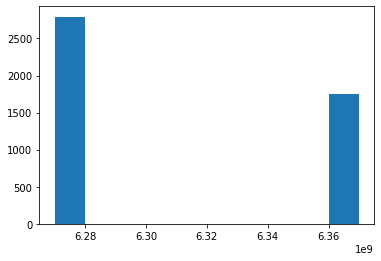

In [46]:
plt.hist(6.27e9*(bam_mappings.sex_numeric.astype(float)==1.0) + 6.37e9*(bam_mappings.sex_numeric.astype(float)==2.0))

In [40]:
min(total_mapped_reads*150)

80081846816.61873

In [42]:
Counter(bam_mappings.sex_numeric)

Counter({'1.0': 2793, '2.0': 1757})